# Object Detection
模型: `facebook/detr-resnet-50`  
框架: `MindSpore` + `MindSpore NLP`  
环境: 香橙派 AIpro（8T/16G） + Ubuntu + MindSpore 2.6.0 + MindSpore NLP 0.4.1  
目标: 实现目标检测任务，预测图像中每个实体的类别

In [1]:
!pip install mindnlp==0.4.1 pillow sympy 

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
from PIL import Image,ImageDraw
import mindspore as ms
from mindspore import ops, Tensor
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from mindnlp.transformers import DetrImageProcessor, DetrForObjectDetection

/usr/local/miniconda3/envs/img/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/miniconda3/envs/img/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/miniconda3/envs/img/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/miniconda3/envs/img/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


### 加载模型

In [3]:
# 初始化处理器和模型
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")


  0%|          | 0.00/290 [00:00<?, ?B/s]

0.00B [00:00, ?B/s]

  0%|          | 0.00/159M [00:00<?, ?B/s]

[MS_ALLOC_CONF]Runtime config:  enable_vmm:True  vmm_align_size:2MB


Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized: ['model.backbone.conv_encoder.model.embedder.embedder.normalization.num_batches_tracked', 'model.backbone.conv_encoder.model.encoder.stages.0.layers.0.layer.0.normalization.num_batches_tracked', 'model.backbone.conv_encoder.model.encoder.stages.0.layers.0.layer.1.normalization.num_batches_tracked', 'model.backbone.conv_encoder.model.encoder.stages.0.layers.0.layer.2.normalization.num_batches_tracked', 'model.backbone.conv_encoder.model.encoder.stages.0.layers.0.shortcut.normalization.num_batches_tracked', 'model.backbone.conv_encoder.model.encoder.stages.0.layers.1.layer.0.normalization.num_batches_tracked', 'model.backbone.conv_encoder.model.encoder.stages.0.layers.1.layer.1.normalization.num_batches_tracked', 'model.backbone.conv_encoder.model.encoder.stages.0.layers.1.layer.2.normalization.num_batches_tracked', 'model.backbone.conv_encoder.model

### 加载图像并进行推理

In [4]:
image_path = "image.png"
image = Image.open(image_path).convert("RGB")

inputs_np = processor(images=image, return_tensors="np")
inputs = {k: Tensor(v, dtype=ms.float32) for k, v in inputs_np.items()}

outputs = model(**inputs)

### 对推理结果进行处理提取出识别结果内容

In [5]:

target_sizes = Tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

Detected cat with confidence 0.999 at location [847.93, 555.88, 1157.75, 796.89]
Detected dog with confidence 0.985 at location [292.15, 317.87, 580.77, 804.21]
Detected cat with confidence 0.998 at location [164.4, 428.88, 367.94, 793.64]
Detected dog with confidence 0.997 at location [573.06, 248.01, 859.52, 796.9]


### 展示识别结果

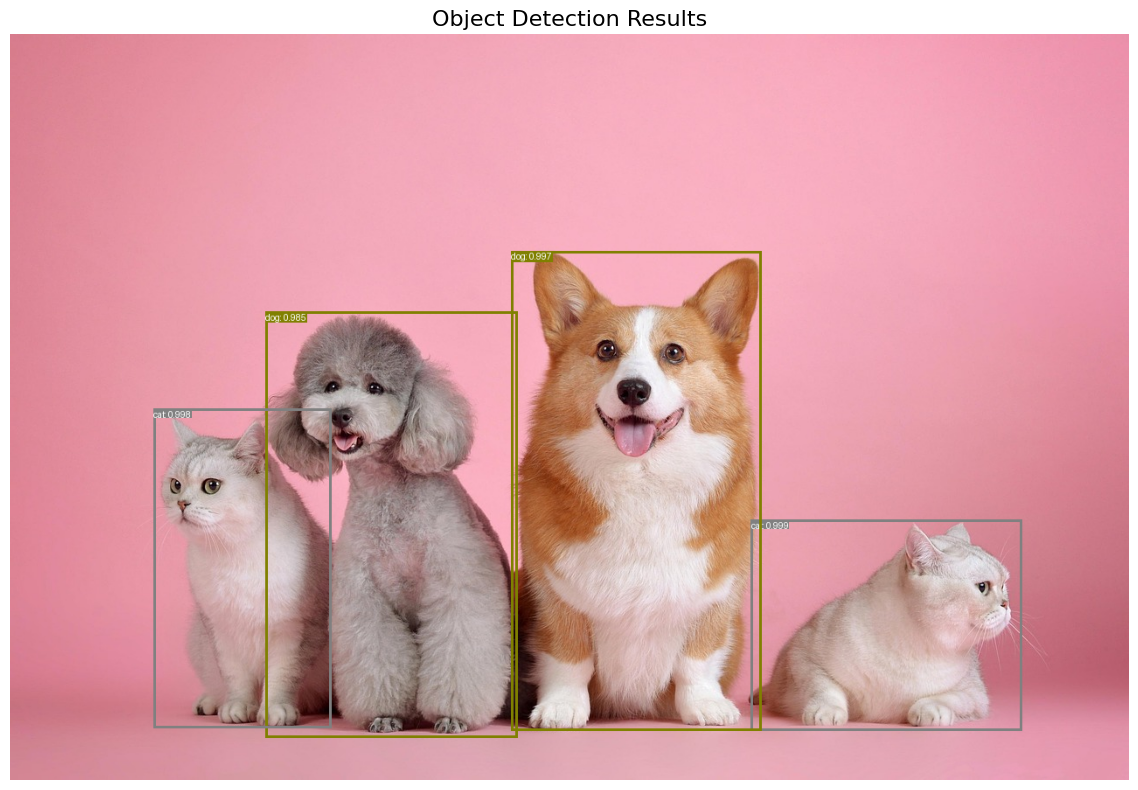

In [6]:
# 创建图像副本用于绘制
image_with_boxes = image.copy()
draw = ImageDraw.Draw(image_with_boxes)

# 设置颜色列表
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

# 绘制边界框和标签
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    # 转换坐标
    box = [round(i, 2) for i in box.tolist()]
    x_min, y_min, x_max, y_max = box
    
    # 获取类别名称和置信度
    class_name = model.config.id2label[label.item()]
    confidence = round(score.item(), 3)
    
    # 选择颜色
    color_idx = label.item() % len(colors)
    color = colors[color_idx]
    
    # 绘制边界框
    draw.rectangle([x_min, y_min, x_max, y_max], outline=color, width=3)
    
    # 绘制标签背景
    label_text = f"{class_name}: {confidence}"
    bbox = draw.textbbox((x_min, y_min), label_text)
    draw.rectangle(bbox, fill=color)
    
    # 绘制标签文本
    draw.text((x_min, y_min), label_text, fill="white")

# 使用matplotlib显示
plt.figure(figsize=(12, 8))
plt.imshow(np.array(image_with_boxes))
plt.axis('off')
plt.title('Object Detection Results', fontsize=16)
plt.tight_layout()
plt.show()

